# SingleCell Data Analysis on the GPU with Pearson Residuals
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 200000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell.scanpy_gpu_funcs as rsf
from rapids_singlecell.cunnData import cunnData


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/200000.h5ad")
adata.var_names_make_unique()

CPU times: user 220 ms, sys: 440 ms, total: 660 ms
Wall time: 659 ms


In [5]:
adata.shape

(200000, 27998)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 1.19 s, sys: 1.25 s, total: 2.44 s
Wall time: 2.43 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(200000, 27998)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

399277814

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 3.123497247695923


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
cudata.flag_gene_family(gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 5.46 ms, sys: 1.05 ms, total: 6.51 ms
Wall time: 6.41 ms


In [12]:
%%time
cudata.caluclate_qc(qc_vars=["MT"])

CPU times: user 450 ms, sys: 90.7 ms, total: 541 ms
Wall time: 538 ms


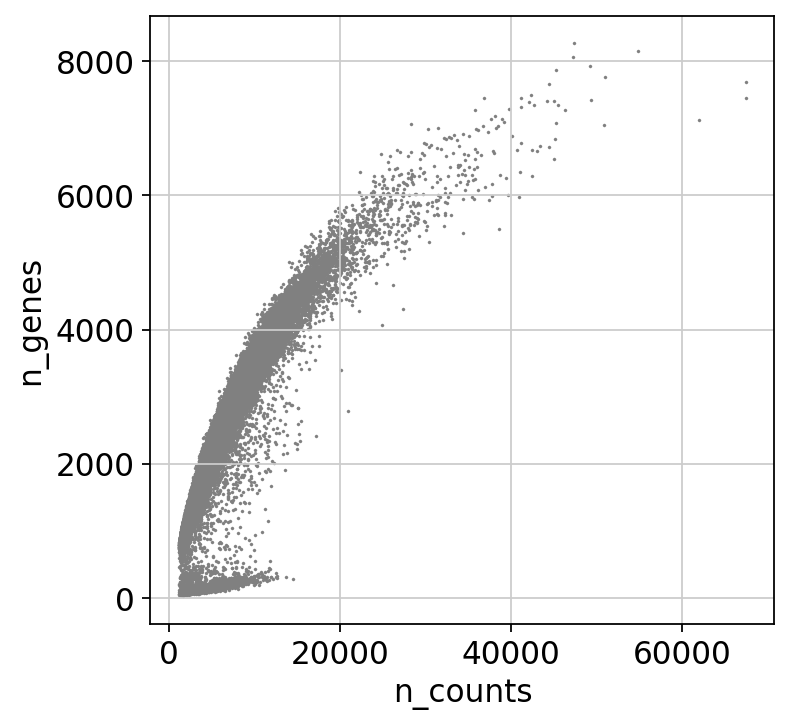

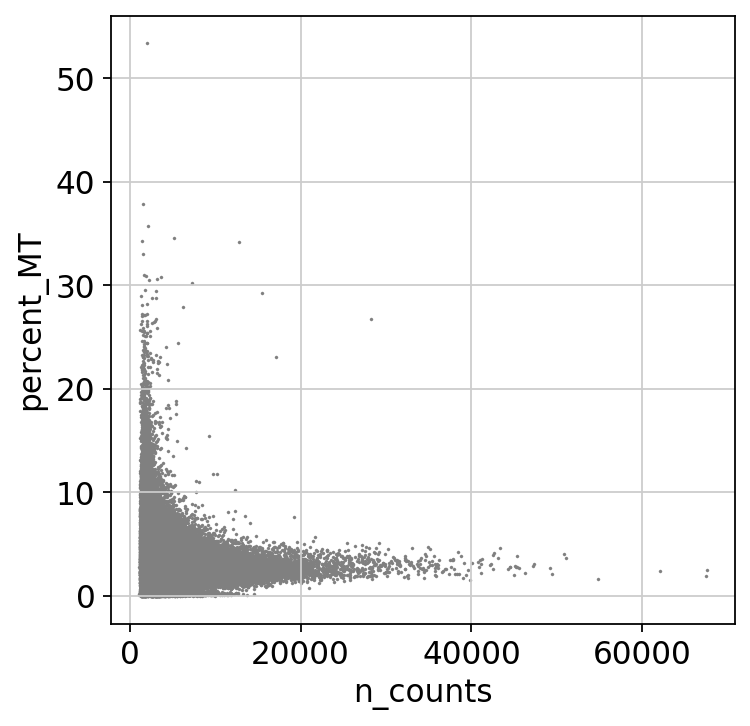

In [13]:
rsf.plt_scatter(cudata,"n_counts","n_genes")
rsf.plt_scatter(cudata,"n_counts","percent_MT")

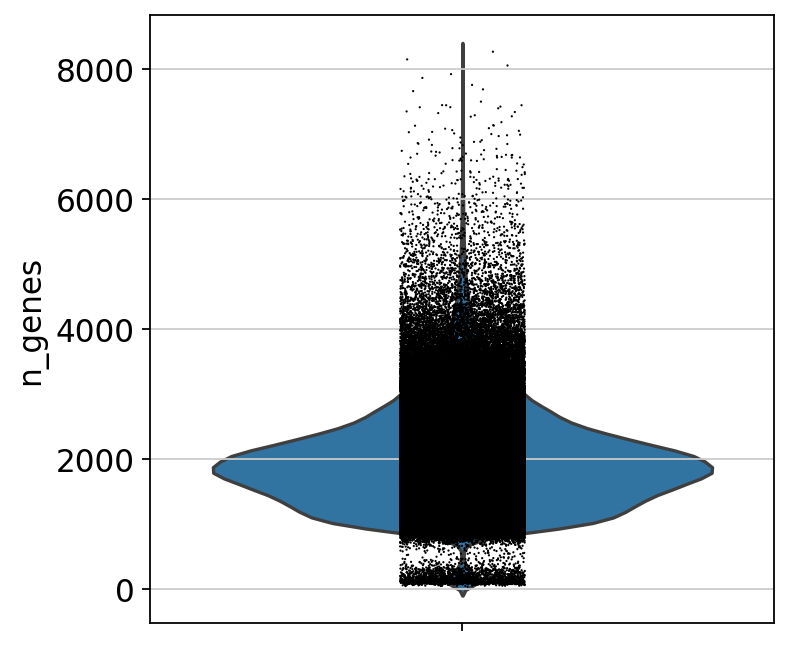

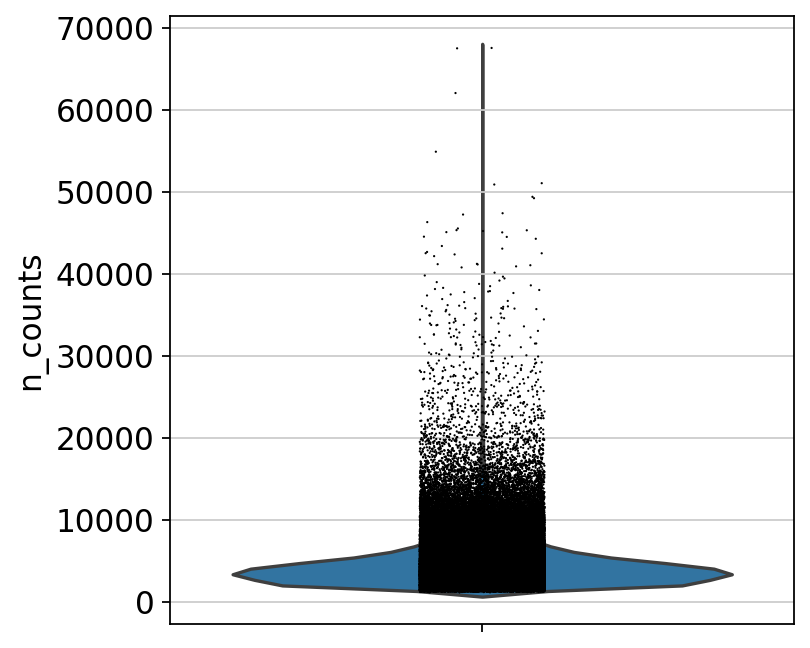

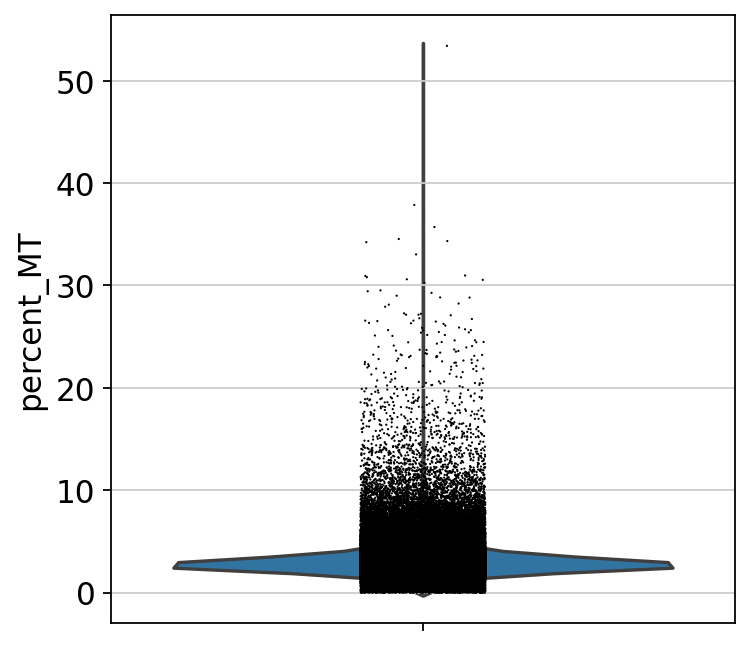

In [14]:
rsf.plt_violin(cudata,key="n_genes")
rsf.plt_violin(cudata,key="n_counts")
rsf.plt_violin(cudata,key="percent_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [15]:
%%time
cudata.filter_cells(qc_var="n_genes", min_count=500,max_count= 4000)
cudata.filter_cells(qc_var="n_counts", max_count= 20000)
cudata = cudata[cudata.obs["percent_MT"] < 10]

filtered out 6066 cells
filtered out 2 cells
CPU times: user 37.6 ms, sys: 30.2 ms, total: 67.8 ms
Wall time: 66.5 ms


We copy the raw counts to the layer `counts`

In [16]:
cudata.layers["counts"] = cudata.X.copy()

### Log-Normalize counts

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
cudata.normalize_total(target_sum=1e4)

CPU times: user 1.47 ms, sys: 528 µs, total: 1.99 ms
Wall time: 1.1 ms


Next, we log transform the count matrix.

In [18]:
cudata.log1p()

Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [19]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 466 ms, sys: 369 ms, total: 835 ms
Wall time: 833 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `pearson_residuals` for selecting highly variable genes `.layer["counts"]`

In [20]:
%%time
cudata.highly_varible_genes(n_top_genes=5000,flavor="pearson_residuals",layer = "counts")

CPU times: user 7.54 s, sys: 1.04 s, total: 8.58 s
Wall time: 8.58 s


Now we restrict our cunndata object to the highly variable genes.

In [21]:
%%time
cudata.filter_highly_variable()

CPU times: user 142 ms, sys: 23 ms, total: 165 ms
Wall time: 163 ms


In [22]:
cudata.shape

(192398, 5000)

### Normalize

We normalize the raw counts matrix with pearson_residuals.

In [23]:
%%time
cudata.layers["pearson_residuals"] = cudata.normalize_pearson_residuals(layer= "counts",inplace = False)

CPU times: user 2.23 s, sys: 202 ms, total: 2.43 s
Wall time: 2.64 s


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [24]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 774 ms, sys: 814 ms, total: 1.59 s
Wall time: 1.59 s


In [25]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 17.513015508651733


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [26]:
%%time
rsf.pca(adata, n_comps = 100, layer = "pearson_residuals")

CPU times: user 2.6 s, sys: 1.79 s, total: 4.39 s
Wall time: 4.38 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

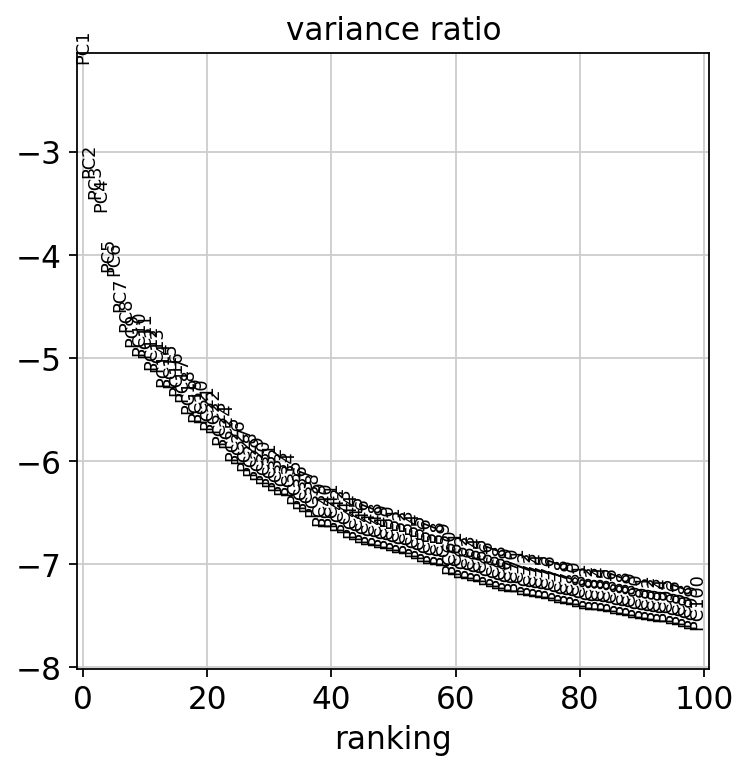

In [27]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [28]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 8.24 s, sys: 331 ms, total: 8.57 s
Wall time: 8.34 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [29]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 1.4 s, sys: 91.4 ms, total: 1.49 s
Wall time: 1.49 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [30]:
%%time
rsf.louvain(adata, resolution=1)

CPU times: user 293 ms, sys: 96 ms, total: 389 ms
Wall time: 387 ms


In [31]:
%%time
rsf.leiden(adata,resolution=1)

CPU times: user 297 ms, sys: 128 ms, total: 425 ms
Wall time: 424 ms


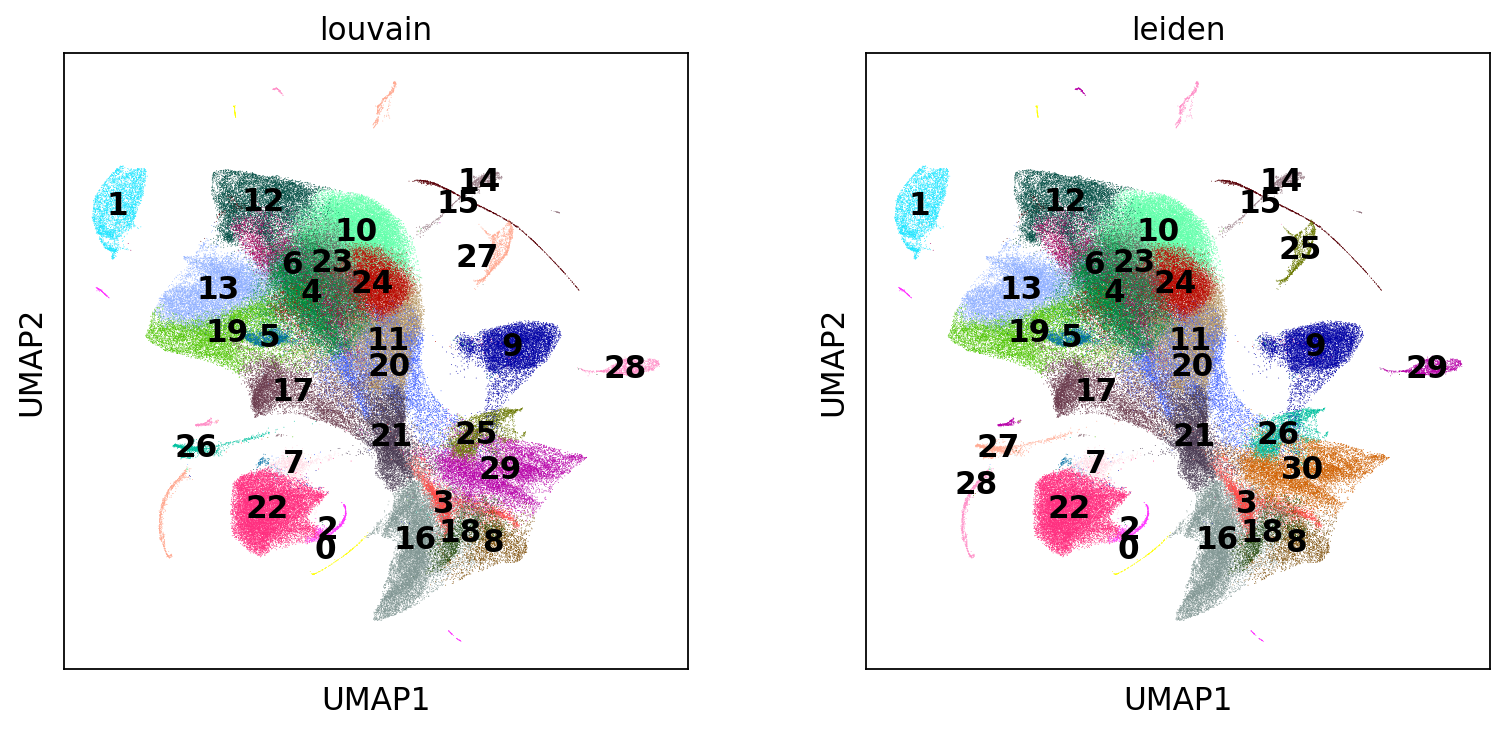

CPU times: user 1.39 s, sys: 140 ms, total: 1.53 s
Wall time: 1.33 s


In [32]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

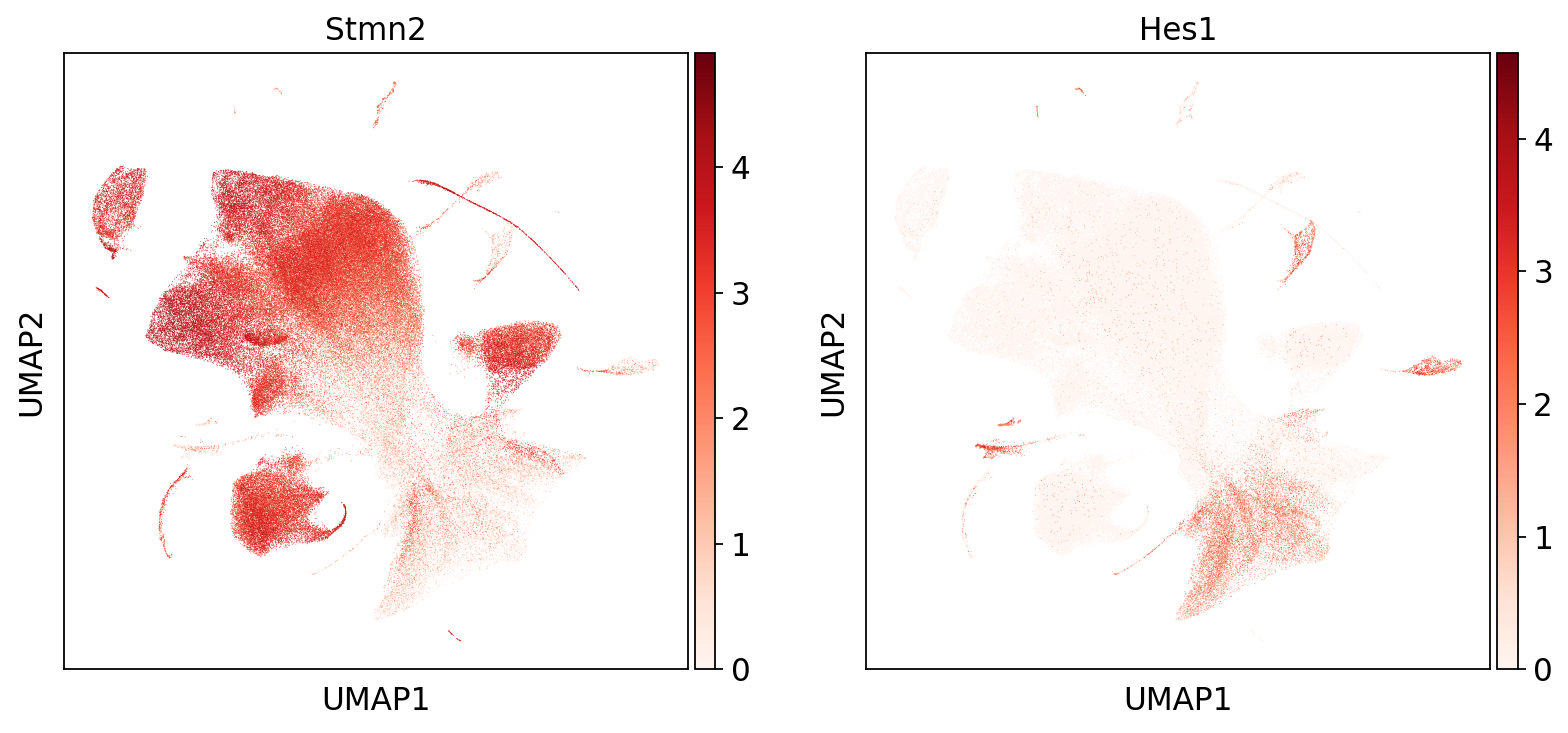

CPU times: user 1.65 s, sys: 155 ms, total: 1.81 s
Wall time: 1.59 s


In [33]:
%%time
sc.pl.umap(adata, color=["Stmn2","Hes1"],legend_loc = 'on data', cmap="Reds")

In [34]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 35.72882890701294
